# Latent Dirichlet Allocation

_Done By: Shivika Sharma_


<b>Latent Dirichlet Allocation</b> is a model used to learn _latent topics_ present in the corpus. The output of LDA can further be used for tasks like document classification. <br>

This script is an attempt to a simpler version of implement latent dirichlet allocation from scratch to cluster documents using Markov Chain Monte Carlo Method (i.e. using Gibbs sampling) for a particular training dataset without actually learning α or β LDA parameters.



The dataset used in the script is the 20 Newsgroups dataset imported from sklearn. <br>
For sake of computation, the script only focuses on two groups in the dataset. These 2 groups are those with the highest number of words (17 and 2) since that gives more data in training the simple LDA model. <br>
Thus, filtering out all those sample points where the y labels are not 17 or 2.

The script then makes use of the output of LDA to classify the documents using Support Vector Machines from sklearn library

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import re
from tqdm import tqdm

In [3]:
!pip3 install nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [73]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [549]:
from sklearn import metrics
from sklearn import svm
from collections import defaultdict

## Analysis of the dataset

In [454]:
# Importing the dataset
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
newsgroups = fetch_20newsgroups()
X1 = newsgroups.data
y1 = newsgroups.target

In [456]:
set(y1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [550]:
words = defaultdict(int)
for label in set(y1):
    temp_X = ([x for i, x in enumerate(X1) if y1[i]==label])
    if temp_X:
        words[label] = len(list(set([word for sample in temp_X for word in sample.split()])))
    else:
        words[label] = 0
words = dict(sorted(words.items(), key=lambda item: item[1]))

In [551]:
words

{4: 18937,
 6: 21251,
 9: 21389,
 3: 21570,
 12: 21767,
 8: 21957,
 19: 22097,
 7: 22330,
 0: 23253,
 1: 26184,
 15: 27595,
 18: 27639,
 10: 27829,
 16: 27850,
 5: 28208,
 13: 28747,
 11: 29811,
 14: 31454,
 17: 31984,
 2: 36164}

Clearly groups 17 and 2 have the most number of words

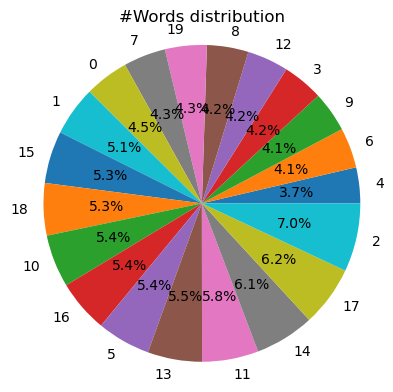

In [553]:
# Analysing the distribution of data between labels
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.pie(words.values(), labels = words.keys(), autopct='%1.1f%%')
ax.set_title('#Words distribution')
plt.axis('equal')
plt.show()

In [495]:
X = [x for i, x in enumerate(X1) if y1[i] in [17, 2]]
y = [y1[i] for i, y_i in enumerate(y1) if y_i in [17, 2]] 

In [496]:
# Analysing the dataset
print("Number of documents - ", len(y))
print("Supervised labels of documents - ", set(y))
print("\nSample document - \n", X[0])

# Checking if the dataset is complete
assert(len(X) == len(y))

Number of documents -  1155
Supervised labels of documents -  {17, 2}

Sample document - 
 From: holmes7000@iscsvax.uni.edu
Subject: WIn 3.0 ICON HELP PLEASE!
Organization: University of Northern Iowa
Lines: 10

I have win 3.0 and downloaded several icons and BMP's but I can't figure out
how to change the "wallpaper" or use the icons.  Any help would be appreciated.


Thanx,

-Brando

PS Please E-mail me




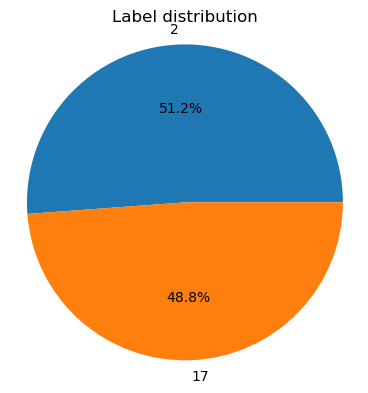

In [497]:
# Analysing the distribution of data between labels
label_freq = Counter(y)
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.pie(label_freq.values(), labels = label_freq.keys(), autopct='%1.1f%%')
ax.set_title('Label distribution')
plt.axis('equal')
plt.show()

## Test-Train Split

Splitting the dataset into 80% test and 20% training set after shuffling it

In [498]:
# Shuffling the dataset
data = list(zip(X, y))
random.shuffle(data)
X, y = zip(*data)
X = list(X)

In [499]:
len_train = int(0.8*len(y))

In [500]:
X_train = X[:len_train]
y_train = y[:len_train]

X_test = X[len_train:]
y_test = y[len_train:]

In [501]:
len(X_train)

924

In [502]:
len(X_test)

231

## Data Preprocessing 
Preprocessing is very important since the model is trained on the words in documents. Removal of unnecessary words and stemming is vital for the performance of the model as well as to decrease the vocabulary and thus computation (in terms of both Time and Space). <br> <br>
Preprocessing done - 
- Removal of special characters
- Removal of stopwords
- Lowercasing 
- Stemming
- Removal of numbers

In [503]:
stop_words = ["from", "subject", "re", "organization", "lines", "thanks"]
special_chars = ['!', '#', '$', '%', '^', '&', '*', '-', '+', '=', '~', '\\', '|', '/', ':', ';', ',', '.', '?', ')', '(', '{', '}', '<', '>', '[', ']', '~', '.', '"', "'", '_']

In [504]:
# This function removes the special characters provided
# It also removes email addresses and new line characters from text and 
# separates words separated by hyphens
def remove_special_chars(X_train, special_chars = special_chars):
  translator = str.maketrans('', '', ''.join(special_chars))
  for i in range(len(X_train)):
    X_train[i] = re.sub(r'\S+@\S+', '', X_train[i])
    X_train[i] = re.sub(r'@\w+', '', X_train[i])
    X_train[i] = X_train[i].replace('-', ' ')
    X_train[i] = X_train[i].replace('\n', ' ')
    X_train[i] = X_train[i].translate(translator)

In [505]:
def remove_stop_words(X_train, stopwords = stopwords):
  for i in range(len(X_train)):
    words = X_train[i].split()
    words = [word for word in words if word.lower() not in stopwords]
    X_train[i] = ' '.join(words)

In [506]:
def lowercase(X_train):
  for i in range(len(X_train)):
    X_train[i] = X_train[i].lower()

In [507]:
def stemming(X_train):
  stemmer = PorterStemmer()
  for i in range(len(X_train)):
    X_train[i] = [stemmer.stem(word) for word in X_train[i].split()]
    X_train[i] = ' '.join(X_train[i])

In [508]:
def remove_nums(X_train):
  for i in range(len(X_train)):
    X_train[i] = re.sub(r'\d+', '', X_train[i])

In [509]:
def preprocess_data(X):
    remove_special_chars(X)
    remove_stop_words(X, stop_words)
    remove_stop_words(X, stopwords.words('english'))
    lowercase(X)
    stemming(X)
    remove_nums(X)

In [510]:
X_train[0]

"From: A.D.Bailey@lut.ac.uk\nSubject: Re: Utility for updating Win.ini and system.ini\nReply-To: A.D.Bailey@lut.ac.uk (Adrian D.Bailey)\nOrganization: Loughborough University, UK.\nLines: 11\n\nIn article <1993Apr20.085638.29338@news.uit.no> sp@odin.NoSubdomain.NoDomain (Svein Pedersen) writes:\n>I nead a utility for updating (deleting, adding, changing) *.ini files for Windows. \n>\n>Do I find it on any FTP host?\n>\n>Svein\n>\n\n\nIn Windows 3.0 there is a built-in called sysedit.exe that is just what you\nneed.   Windows 3.1 I don't know......\n"

In [511]:
remove_special_chars(X_train)

In [512]:
X_train[0]

'From  Subject Re Utility for updating Winini and systemini Reply To  Adrian DBailey Organization Loughborough University UK Lines 11  In article   Svein Pedersen writes I nead a utility for updating deleting adding changing ini files for Windows   Do I find it on any FTP host  Svein    In Windows 30 there is a built in called syseditexe that is just what you need   Windows 31 I dont know '

In [513]:
remove_stop_words(X_train, stop_words)
nltk.download('stopwords')
remove_stop_words(X_train, stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [514]:
X_train[0]

'Utility updating Winini systemini Reply Adrian DBailey Loughborough University UK 11 article Svein Pedersen writes nead utility updating deleting adding changing ini files Windows find FTP host Svein Windows 30 built called syseditexe need Windows 31 dont know'

In [515]:
lowercase(X_train)

In [516]:
X_train[0]

'utility updating winini systemini reply adrian dbailey loughborough university uk 11 article svein pedersen writes nead utility updating deleting adding changing ini files windows find ftp host svein windows 30 built called syseditexe need windows 31 dont know'

In [517]:
stemming(X_train)

In [518]:
X_train[0]

'util updat winini systemini repli adrian dbailey loughborough univers uk 11 articl svein pedersen write nead util updat delet ad chang ini file window find ftp host svein window 30 built call syseditex need window 31 dont know'

In [519]:
remove_nums(X_train)

In [520]:
X_train[0]

'util updat winini systemini repli adrian dbailey loughborough univers uk  articl svein pedersen write nead util updat delet ad chang ini file window find ftp host svein window  built call syseditex need window  dont know'

In [521]:
preprocess_data(X_train)

## Training a simple LDA model using Gibbs Sampling

In [522]:
# Initialising hyperparameters
num_topics = 10
alpha = 1
beta = 1
num_iters = 20

In [523]:
# Vocabulary in dataset
vocab = list(set([word for sample in X_train for word in sample.split()]))

In [524]:
len(vocab)

24779

In [525]:
# Randomly initialising words in documents to topics
topic_assignments = np.random.randint(num_topics, size=(len(X_train), len(vocab)))

In [526]:
topic_assignments[0][0]

6

In [528]:
# Since not all words are present in every document, we set those topic assignments as -1
for d, document in tqdm(enumerate(X_train)):
  for j in range(len(vocab)):
    if vocab[j] not in document.split():
      topic_assignments[d, j] = -1 


924it [02:58,  5.18it/s]


In [529]:
# Creating dictionary to keep track of words in documents (as they can be repeated or not present in the document)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

In [530]:
# List of topic-word count
topic_word_count = np.zeros((num_topics, len(vocab)))
for d, document in enumerate(X_train):
    for w, word in enumerate(document.split()): 
        topic_word_count[topic_assignments[d,word_to_index[word]], word_to_index[word]] += 1

In [531]:
# List of document-topic counts
doc_topic_count = np.zeros((len(X_train), num_topics))
for d, document in enumerate(X_train):
    for w, word in enumerate(document.split()): 
        doc_topic_count[d, topic_assignments[d,word_to_index[word]]] += 1

In [532]:
# Given a topic, word and document, this function 
#returns the probability of that word in the document being associated to the given topic
def calculate_prob(topic, word, doc_index, epsilon=0.1):
  numer = (doc_topic_count[d][topic] + alpha) * (topic_word_count[topic][word_to_index[word]])
  denom = (np.sum(doc_topic_count[d][:]) + num_topics * alpha) * (np.sum(topic_word_count[:, word_to_index[word]]) + len(vocab) * beta)
  return (numer/denom) + epsilon

In [533]:
# Gibbs sampling
for _ in tqdm(range(num_iters)):
  for d, document in enumerate(X_train):
    for w, word in enumerate(document.split()): 

      # Decrementing the current count
      topic_word_count[topic_assignments[d][word_to_index[word]]][word_to_index[word]] -= 1
      doc_topic_count[d][topic_assignments[d][word_to_index[word]]] -= 1

      # Calculating the conditional probability for all topics given word w and document d
      topic_probs = [calculate_prob(topic, word, d) for topic in range(num_topics)]
      topic_probs = [prob/sum(topic_probs) for prob in topic_probs]

      # Sampling a new topic from a multinomial distribution given topic_probs
      topic_assignments[d][word_to_index[word]] = np.random.choice(num_topics, p=topic_probs)

      # Increment values for new topic
      topic_word_count[topic_assignments[d,word_to_index[word]]][word_to_index[word]] += 1
      doc_topic_count[d][topic_assignments[d][word_to_index[word]]] += 1



100%|███████████████████████████████████████████| 20/20 [05:05<00:00, 15.29s/it]


In [534]:
doc_topic_count[0]

array([1., 6., 4., 3., 4., 5., 3., 2., 5., 2.])

In [535]:
# Given a topic this function returns the top 'num_top_words' words associated with it (with highest probabilities)
def find_top_words(topic, num_top_words):
  probs = [topic_word_count[topic][word_to_index[word]] for word in vocab]
  indices = np.argpartition(probs, -num_top_words)[-num_top_words:]
  return [vocab[i] for i in indices]

In [536]:
num_top_words = 10
print("Top 10 words of topics - \n")
for topic in range(num_topics):
  print("Topic ", topic+1, end = '\t')
  print(find_top_words(topic, num_top_words))

Top 10 words of topics - 

Topic  1	['think', 'israel', 'write', 'articl', 'use', 'u', 'file', 'window', 'one', 'armenian']
Topic  2	['use', 'one', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'window', 'font', 'say', 'didnt', 'peopl', 'turkey', 'said']
Topic  3	['univ', 'armenian', 'write', 'one', 'window', 'articl', 'get', 'use', 'would', 'peopl']
Topic  4	['articl', 'one', 'turkish', 'go', 'write', 'would', 'know', 'window', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'armenian']
Topic  5	['u', 'right', 'use', 'peopl', 'window', 'know', 'turkish', 'say', 'one', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax']
Topic  6	['articl', 'window', 'israel', 'write', 'time', 'isra', 'armenian', 'peopl', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'one']
Topic  7	['articl', 'write', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'one', 'armenian', 'use', 'dont', 'would', 'window', 'go']
Topic  8	['write', 'use', 'univ', 'file', 'jew', 'window', 'p', 'armenian', 'said', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax']
Topic  9	['would', 'use', 'one', 'peopl', '

_**Observation:**_ <br>
- The intersection of the set of top words associated with the topics has high cardinality. 
- This indicates that the topics have less semantic meaning.

In [537]:
# Given a document this function returns a list of the probabilities with which it is associated to a topic
def find_theta(d):
  probs = [(doc_topic_count[d][k]/np.sum(doc_topic_count[d][:])) for k in range(num_topics)]
  return probs

In [538]:
SVM_X = []
# Finding the topic probabilities for each document as the sample points for SVM
for d, document in enumerate(X_train):
  SVM_X.append(find_theta(d))
SVM_y = y_train

In [539]:
clf = svm.SVC(kernel='rbf')
clf.fit(SVM_X, SVM_y)

SVC()

In [540]:
y_pred = clf.predict(SVM_X)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))

Accuracy: 0.7348484848484849


In [541]:
freq = Counter(y_pred)
print("Predicted labels: ", freq)
freq = Counter(SVM_y)
print("Actual labels: ", freq)

Predicted labels:  Counter({17: 466, 2: 458})
Actual labels:  Counter({2: 487, 17: 437})


## Using this trained model on the test data

In [542]:
# Given a word, this function returns the topic it is most likely associated to
def find_word_topic(word):
    probs = topic_word_count[:, word_to_index[word]]
    return np.argmax(probs)

In [544]:
preprocess_data(X_test)

In [546]:
X_SVM_test = []
# Finding the topic probabilities for each test document as the sample points for SVM
for d, document in tqdm(enumerate(X_test)):
    doc_topics = defaultdict(int)
    for w, word in enumerate(document.split()):
        if word in vocab:
            if find_word_topic(word) > -1:
                doc_topics[find_word_topic(word)] += 1
                
    theta = [doc_topics[t] for t in range(num_topics)]
    theta = [t/sum(theta) for t in theta]
    X_SVM_test.append(theta)
            

231it [00:06, 36.91it/s]


In [548]:
y_test_pred = clf.predict(X_SVM_test)
print("Accuracy:",metrics.accuracy_score(y_test_pred, y_test))

Accuracy: 0.5800865800865801


_**Conclusions:**_
- The model takes about 8 minutes to train. 
- The accuracy of the classifier on the training data is about 74%. Although, the classifier performs poorly on the test set since the accuracy is only a little over 58%. <br>
- We can further improve this model by 
    - Taking a larger dataset
    - Implementing LDA in a way to learn the model parameters α and β. 
    - Use a validation set to find the optimal number of iterations for the gibbs sampler.
    - Using Tf-idf values for the terms in the documents to give more weightage to terms with higher Tf-idf values in a particular document.